In [76]:
from numpy import loadtxt

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("data.csv", parse_dates=["date"], index_col="date")
df.sort_index(inplace=True)
df = df.dropna()
df.describe()

,DGS1,DGS10,DGS1MO,DGS2,DGS30,DGS3MO,DGS5
count,5311.000000,5311.000000,5311.000000,5311.000000,5311.000000,5311.000000,5311.000000
mean,1.481246,3.022243,1.188759,1.714310,3.694547,1.253421,2.370665
std,1.482722,1.183672,1.442171,1.416629,1.137176,1.470054,1.276787
min,0.040000,0.520000,0.000000,0.090000,0.990000,0.000000,0.190000
25%,0.210000,2.050000,0.060000,0.520000,2.870000,0.090000,1.410000
50%,1.110000,2.860000,0.530000,1.320000,3.580000,0.790000,2.100000
75%,2.280000,4.080000,1.830000,2.610000,4.690000,1.910000,3.270000
max,5.300000,5.440000,5.270000,5.290000,5.920000,5.190000,5.230000


In [18]:
# generate the target variable in the future X rows
target_col = "DGS10"
df["target"] = df[target_col].shift(-10)
cols = df.columns.tolist()
cols.remove("target")
input_columns = cols.copy()

print("--------- inputs -----------")
print(df[input_columns].head(5))

print("--------- target -----------")
print(df["target"].head(5))

--------- inputs -----------
            DGS1  DGS10  DGS1MO  DGS2  DGS30  DGS3MO  DGS5
date                                                      
2001-07-31  3.53   5.07    3.67  3.79   5.51    3.54  4.57
2001-08-01  3.56   5.11    3.65  3.83   5.53    3.53  4.62
2001-08-02  3.57   5.17    3.65  3.89   5.57    3.53  4.69
2001-08-03  3.57   5.20    3.63  3.91   5.59    3.52  4.72
2001-08-06  3.56   5.19    3.62  3.88   5.59    3.52  4.71
--------- target -----------
date
2001-07-31    4.97
2001-08-01    5.00
2001-08-02    4.95
2001-08-03    4.84
2001-08-06    4.91
Name: target, dtype: float64


In [92]:
SPLIT_DATE_STR = '06-01-2020'

train = df.loc[df.index < SPLIT_DATE_STR].dropna()
test = df.loc[df.index >= SPLIT_DATE_STR].dropna()

train.tail(), test.head(), test.tail()

(            DGS1  DGS10  DGS1MO  DGS2  DGS30  DGS3MO  DGS5  target
 date                                                              
 2020-05-22  0.17   0.66    0.09  0.17   1.37    0.12  0.34    0.88
 2020-05-26  0.17   0.69    0.10  0.18   1.43    0.14  0.35    0.84
 2020-05-27  0.18   0.68    0.11  0.19   1.44    0.15  0.34    0.75
 2020-05-28  0.17   0.70    0.14  0.17   1.47    0.15  0.34    0.66
 2020-05-29  0.17   0.65    0.13  0.16   1.41    0.14  0.30    0.71,
             DGS1  DGS10  DGS1MO  DGS2  DGS30  DGS3MO  DGS5  target
 date                                                              
 2020-06-01  0.17   0.66    0.12  0.14   1.46    0.14  0.31    0.71
 2020-06-02  0.17   0.68    0.12  0.17   1.48    0.15  0.32    0.75
 2020-06-03  0.17   0.77    0.12  0.19   1.56    0.16  0.38    0.74
 2020-06-04  0.17   0.82    0.13  0.19   1.61    0.15  0.40    0.71
 2020-06-05  0.18   0.91    0.13  0.22   1.68    0.15  0.47    0.70,
             DGS1  DGS10  DGS1MO  DGS2  DGS30 

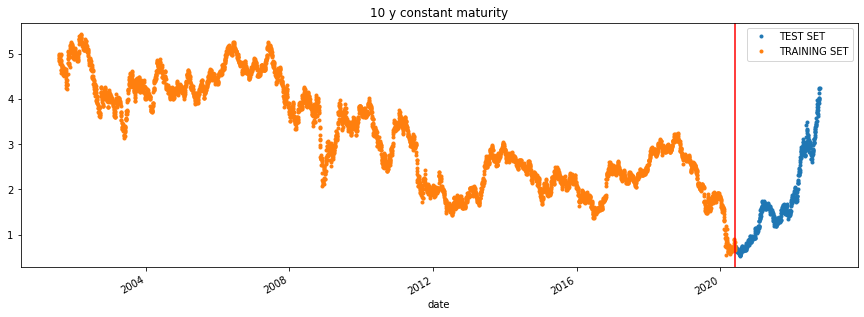

In [93]:
xplot = (
    test[['target']]
    .rename(columns={'target': 'TEST SET'})
    .join(train[['target']].rename(columns={'target': 'TRAINING SET'}), how='outer')
    .plot(figsize=(15,5), title='10 y constant maturity', style='.')
)

plt.axvline(SPLIT_DATE_STR, color='red')

In [94]:
df.columns

Index(['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS30', 'DGS3MO', 'DGS5', 'target'], dtype='object')

In [95]:
def create_features(df):
    xdf = df.copy()
    x = xdf[['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS30', 'DGS3MO', 'DGS5']].copy()
    y = xdf['target']
    return (x,y)

X_train, y_train = create_features(train)
X_test, y_test = create_features(test)

In [104]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:2.03752	validation_1-rmse:1.10507
[1]	validation_0-rmse:1.43330	validation_1-rmse:0.82204
[2]	validation_0-rmse:1.01137	validation_1-rmse:0.63376
[3]	validation_0-rmse:0.71749	validation_1-rmse:0.51385
[4]	validation_0-rmse:0.51405	validation_1-rmse:0.44020
[5]	validation_0-rmse:0.37404	validation_1-rmse:0.40026
[6]	validation_0-rmse:0.27797	validation_1-rmse:0.37578
[7]	validation_0-rmse:0.21459	validation_1-rmse:0.35980
[8]	validation_0-rmse:0.17338	validation_1-rmse:0.34903
[9]	validation_0-rmse:0.14691	validation_1-rmse:0.34199
[10]	validation_0-rmse:0.13078	validation_1-rmse:0.33623
[11]	validation_0-rmse:0.12121	validation_1-rmse:0.32592
[12]	validation_0-rmse:0.11431	validation_1-rmse:0.32367
[13]	validation_0-rmse:0.11077	validation_1-rmse:0.32241
[14]	validation_0-rmse:0.10809	validation_1-rmse:0.32106
[15]	validation_0-rmse:0.10569	validation_1-rmse:0.32045
[16]	validation_0-rmse:0.10398	validation_1-rmse:0.31911
[17]	validation_0-rmse:0.10200	validation

/Users/vifo/.pyenv/versions/3.8.9/envs/finx-all/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:0.09532	validation_1-rmse:0.31811
[23]	validation_0-rmse:0.09421	validation_1-rmse:0.31831
[24]	validation_0-rmse:0.09346	validation_1-rmse:0.31848
[25]	validation_0-rmse:0.09255	validation_1-rmse:0.31726
[26]	validation_0-rmse:0.09201	validation_1-rmse:0.31738
[27]	validation_0-rmse:0.09068	validation_1-rmse:0.31726
[28]	validation_0-rmse:0.08964	validation_1-rmse:0.31735
[29]	validation_0-rmse:0.08863	validation_1-rmse:0.31717
[30]	validation_0-rmse:0.08765	validation_1-rmse:0.31875
[31]	validation_0-rmse:0.08678	validation_1-rmse:0.32022
[32]	validation_0-rmse:0.08657	validation_1-rmse:0.32121
[33]	validation_0-rmse:0.08501	validation_1-rmse:0.32172
[34]	validation_0-rmse:0.08448	validation_1-rmse:0.32166
[35]	validation_0-rmse:0.08385	validation_1-rmse:0.32161
[36]	validation_0-rmse:0.08232	validation_1-rmse:0.32108
[37]	validation_0-rmse:0.08162	validation_1-rmse:0.32071
[38]	validation_0-rmse:0.08067	validation_1-rmse:0.32074
[39]	validation_0-rmse:0.08049	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

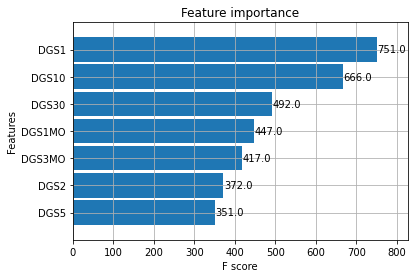

In [97]:
_ = plot_importance(reg, height=0.9)

In [98]:
test['predict'] = reg.predict(X_test)
data_all = pd.concat([test, train], sort=False)

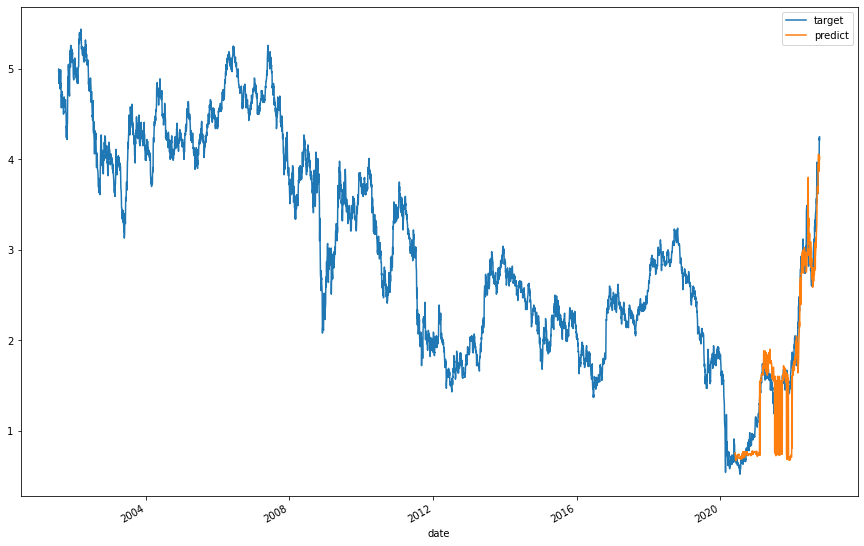

In [99]:
_ = data_all[['target','predict']].plot(figsize=(15, 10))

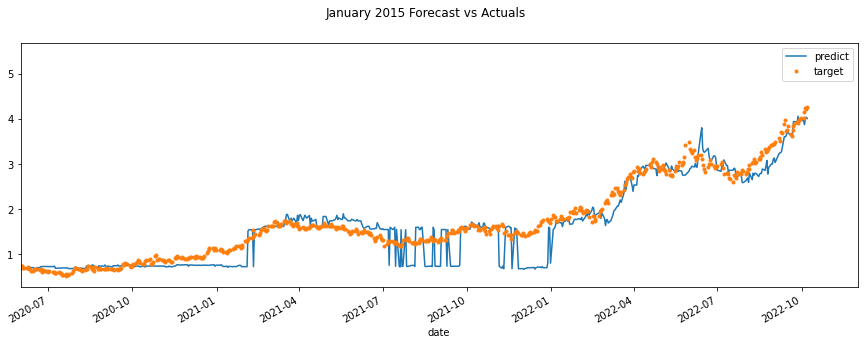

In [101]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax = data_all[['predict', 'target']].plot(ax=ax, style=['-','.'])

ax.set_xbound(lower=SPLIT_DATE_STR, upper='12-01-2022')
plot = plt.suptitle('January 2015 Forecast vs Actuals')


In [102]:
mean_squared_error(y_true=test['target'],
                   y_pred=test['predict'])

0.10059479660348705

In [103]:
mean_absolute_error(y_true=test['target'],
                   y_pred=test['predict'])

0.22832106674442418